# 第 5 章 决策树 Decistion Tree

决策树可以转换成一个 **if-then** 规则的集合，也可以看作是定义在特征空间划分上的类的条件概率分布。

决策树学习旨在构建一个与训练数据拟合很好，并且复杂度小的决策树。

决策树学习算法包括3部分：特征选择、树的生成和树的剪枝。常用的算法有ID3、C4.5和CART。

特征选择的关键是其准则：

- 样本集合 $D$ 对特征 $A$ 的信息增益(**ID3 algorithm**)
$$g(D, A)=H(D)-H(D|A)$$
$$H(D)=-\sum_{k=1}^{K} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$$
$$H(D | A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)$$
其中，$H(D)$ 是数据集 $D$ 的熵，$H(D_i)$ 是数据集 $D_i$ 的熵，$H(D|A)$ 是数据集 $D$ 对特征 $A$ 的条件熵。$D_i$是$D$中特征$A$取第$i$个值的样本子集，$C_k$是$D$中属于第$k$类的样本子集。$n$是特征$A$取 值的个数，$K$是类的个数。

- 样本集合$D$对特征$A$的信息增益比(**C4.5 algorithm**)
$$g_{R}(D, A)=\frac{g(D, A)}{H(D)}$$
其中，$g(D,A)$是信息增益，$H(D)$是数据集$D$的熵。

- 样本集合$D$的基尼指数(**CART alorithm**)
$$\operatorname{Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{\left|C_{k}\right|}{|D|}\right)^{2}$$
特征$A$条件下集合$D$的基尼指数：
 $$\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}\left(D_{1}\right)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}\left(D_{2}\right)$$

  
决策树的生成。通常使用信息增益最大、信息增益比最大或基尼指数最小作为特征选择的准则

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from math import log
from collections import Counter
import pprint  # pprint --- 数据美化输出

In [3]:
# table 5.1 贷款申请样本数据表
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    return datasets, labels

# loadding dataset
datasets, labels = create_data()
train_data = pd.DataFrame(datasets, columns=labels)
print("The dataset shape: {}".format(train_data.shape))
# train_data.head()
# train_data.tail()
train_data

The dataset shape: (15, 5)


,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,非常好,是
9,中年,否,是,非常好,是


### entropy(empirical entropy), conditional entropy(empirical conditional entropy) 
### 当熵和条件熵中的概率计算是由数据估计(特别时极大似然估计)得到前提下

In [4]:
# Calculate empirical entropy
def calculate_entropy(data):
  data_size = len(data)
  num_label = {}
  for i in range(data_size):
    label = data[i][-1]
    if label not in num_label:
      num_label[label] = 0
    num_label[label] += 1
    # compute entropy unit is bit
    entropy = -sum([(p / data_size) * log(p / data_size, 2) for p in num_label.values()])
  return entropy

# Calculate empirical conditional entropy
def calculate_conditional_entropy(data, axis=0):
  data_size = len(data)
  feature_set = {}
  for i in range(data_size):
    feature = data[i][axis]
    if feature not in feature_set:
      feature_set[feature] = []
    feature_set[feature].append(data[i])
  conditional_entropy = sum([(len(p) / data_size) * calculate_entropy(p) for p in feature_set.values()])
  return conditional_entropy

# calculate information gain 信息增益
# mutual information 互信息
def calculate_information_gain(entropy, conditional_entropy):
  return entropy - conditional_entropy

# training with information gain rule.
def information_gain_training(data):
  count = len(data[0]) - 1
  entropy = calculate_entropy(data)
  best_feature = []
  for c in range(count):
    c_information_gain = calculate_information_gain(entropy, calculate_conditional_entropy(data, axis=c))
    best_feature.append((c, c_information_gain))
    print("feature {} -- information gain = {:.6f}".format(labels[c], c_information_gain))
  # select max information gain of feature as RootFeature.
  best = max(best_feature, key=lambda x: x[-1])
  print("---------------------------------------------")
  print("feature {} -- has max information gain, selecting RootFeature".format(labels[best[0]]))
  return best

# -----------------------------------
# TEST
information_gain_training(np.array(datasets))

feature 年龄 -- information gain = 0.083007
feature 有工作 -- information gain = 0.323650
feature 有自己的房子 -- information gain = 0.419973
feature 信贷情况 -- information gain = 0.362990
---------------------------------------------
feature 有自己的房子 -- has max information gain, selecting RootFeature


(2, 0.4199730940219749)

## Using ID3 algorithm to generate Decision Tree.

In [5]:
# the class of Node of binary tree.
class Node:
  def __init__(self, root=True, label=None, feature_name=None, feature=None):
    self.root = root
    self.label = label
    self.feature_name = feature_name
    self.feature = feature
    self.tree = {}
    self.result = {'label': self.label, 'feature': self.feature, 'tree': self.tree}
  
  def __repr__(self):
    return "{}".format(self.result)
  
  def add_node(self, value, node):
    self.tree[value] = node
  
  def predict(self, feature):
    if self.root is True:
      return self.label
    return self.tree[feature[self.feature]].predict(feature)
# ----------------------------------------
# the class of Decision Tree.
class DecisionTree:
  def __init__(self, epsilon=0.1):
    self.epsilon = epsilon
    self._tree = {}
    
  # Calculate empirical entropy
  @staticmethod
  def calculate_entropy(data):
    data_size = len(data)
    num_label = {}
    for i in range(data_size):
      label = data[i][-1]
      if label not in num_label:
        num_label[label] = 0
      num_label[label] += 1
      # compute entropy unit is bit
      entropy = -sum([(p / data_size) * log(p / data_size, 2) for p in num_label.values()])
    return entropy

  # Calculate empirical conditional entropy
  def calculate_conditional_entropy(data, axis=0):
    data_size = len(data)
    feature_set = {}
    for i in range(data_size):
      feature = data[i][axis]
      if feature not in feature_set:
        feature_set[feature] = []
      feature_set[feature].append(data[i])
    conditional_entropy = sum([(len(p) / data_size) * calculate_entropy(p) for p in feature_set.values()])
    return conditional_entropy

  # calculate information gain 信息增益
  # mutual information 互信息
  @staticmethod
  def calculate_information_gain(entropy, conditional_entropy):
    return entropy - conditional_entropy

  # training with information gain rule.
  def information_gain_training(self, data):
    count = len(data[0]) - 1
    entropy = calculate_entropy(data)
    best_feature = []
    for c in range(count):
      c_information_gain = calculate_information_gain(entropy, calculate_conditional_entropy(data, axis=c))
      best_feature.append((c, c_information_gain))
    # select max information gain of feature as RootFeature.
    best = max(best_feature, key=lambda x: x[-1])
    return best
  
  # training with ID3 algorithm.
  def training_ID3(self, train_data):
    """
    input DataFrame Type data
    """
    _, y_train, feature = train_data.iloc[:, :-1], train_data.iloc[:,-1], train_data.columns[:-1]
    # case 1, 
    if len(y_train.value_counts()) == 1:
      return Node(root=True, label=y_train.iloc[0])
    # case 2, 
    if len(feature) == 0:
      return Node(root=True, label=y_tain.value_counts().sort_values(ascending=False).index[0])
    # case 3,
    best_feature, max_information_gain = self.information_gain_training(np.array(train_data))
    best_feature_name = feature[best_feature]
    # case 4, 
    if max_information_gain < self.epsilon:
      return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])
    # case 5, 
    node_tree = Node(root=False, feature_name=best_feature_name, feature=best_feature)
    feature_list = train_data[best_feature_name].value_counts().index
    for f in feature_list:
      sub_train_df = train_data.loc[train_data[best_feature_name] == f].drop([best_feature_name], axis=1)
      sub_tree = self.training_ID3(sub_train_df)
      node_tree.add_node(f, sub_tree)
    # pprint.pprint(node_tree.tree)
    return node_tree
  
  def fit(self, train_data):
    self.tree = self.training_ID3(train_data)
    return self.tree
  
  def predict(self, X_test):
    return self.tree.predict(X_test)

# -----------------------------------------
# TEST
dataset, label = create_data()
data_df = pd.DataFrame(dataset, columns=label)
decision_tree = DecisionTree()
tree = decision_tree.fit(data_df)
print("The simple sample for Test: {}".format(decision_tree.predict(['老年', '否', '否', '一般'])))
print("--------------------------------------")
pprint.pprint(tree)

The simple sample for Test: 否
--------------------------------------
{'label': None, 'feature': 2, 'tree': {'否': {'label': None, 'feature': 1, 'tree': {'否': {'label': '否', 'feature': None, 'tree': {}}, '是': {'label': '是', 'feature': None, 'tree': {}}}}, '是': {'label': '是', 'feature': None, 'tree': {}}}}


## sklearn instance for Decision Tree.

In [10]:
# import packages.
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# precessing data for model.
def create_data():
  iris = load_iris()
  df = pd.DataFrame(iris.data, columns=iris.feature_names)
  df['label'] = iris.target
  df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
  data = np.array(df.iloc[:100, [0, 1, -1]])
  return data[:, :2], data[:, -1]

# loadding data
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train,)
clf.score(X_test, y_test)

1.0

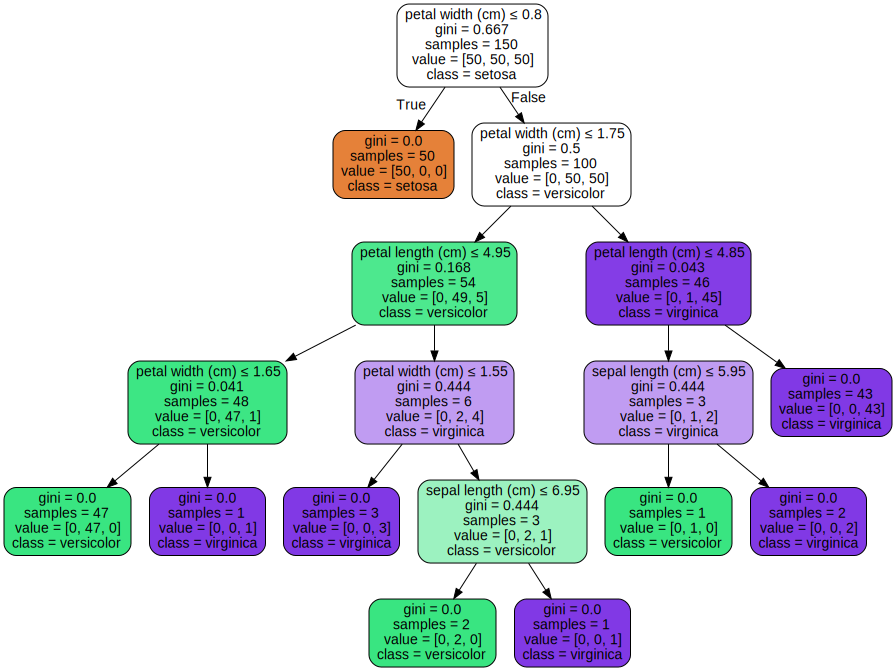

In [14]:
# the Visualization of Decision Trss. 
import graphviz
import os
# https://graphviz.org/download/ --> goto install Graphviz for your Operating System(OS), 
# not only ' pip install graphviz ' graphviz for python package.
os.environ["PATH"] += os.pathsep + "D:/miniconda/Graphviz/bin/"

from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")
# 添加颜色
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=iris.feature_names, 
                                class_names=iris.target_names, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

## 习题 5.1 

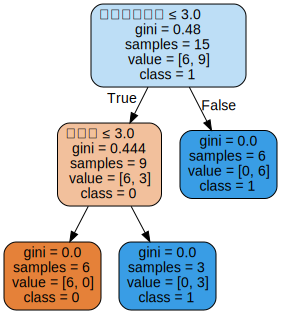

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn import tree
import graphviz
import os
# https://graphviz.org/download/ --> goto install Graphviz for your Operating System(OS), 
# not only ' pip install graphviz ' graphviz for python package.
os.environ["PATH"] += os.pathsep + "D:/miniconda/Graphviz/bin/"

features = ["年龄", "有工作", "有自己的房子", "信贷情况"]
X_train = pd.DataFrame([
    ["青年", "否", "否", "一般"],
    ["青年", "否", "否", "好"],
    ["青年", "是", "否", "好"],
    ["青年", "是", "是", "一般"],
    ["青年", "否", "否", "一般"],
    ["中年", "否", "否", "一般"],
    ["中年", "否", "否", "好"],
    ["中年", "是", "是", "好"],
    ["中年", "否", "是", "非常好"],
    ["中年", "否", "是", "非常好"],
    ["老年", "否", "是", "非常好"],
    ["老年", "否", "是", "好"],
    ["老年", "是", "否", "好"],
    ["老年", "是", "否", "非常好"],
    ["老年", "否", "否", "一般"]])
y_train = pd.DataFrame(["否", "否", "是", "是", "否", 
                        "否", "否", "是", "是", "是", 
                        "是", "是", "是", "是", "否"])
# data preprocessing
le_x = preprocessing.LabelEncoder()
le_x.fit(np.unique(X_train))
X_train = X_train.apply(le_x.transform)
le_y = preprocessing.LabelEncoder()
le_y.fit(np.unique(y_train))
y_train = y_train.apply(le_y.transform)
# call sklearn.DT to train model
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

# the Visualization of Decision Trss. 
dot_data = tree.export_graphviz(model_tree, out_file=None, feature_names=features, 
                                class_names=[str(k) for k in np.unique(y_train)],filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

## 习题5.2

| $x_i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |  
| - | - | - | - | - | - | - | - | - | - | - |  
| $y_i$ | 4.50 | 4.75 | 4.91 | 5.34 | 5.80 | 7.05 | 7.90 | 8.23 | 8.70 | 9.00

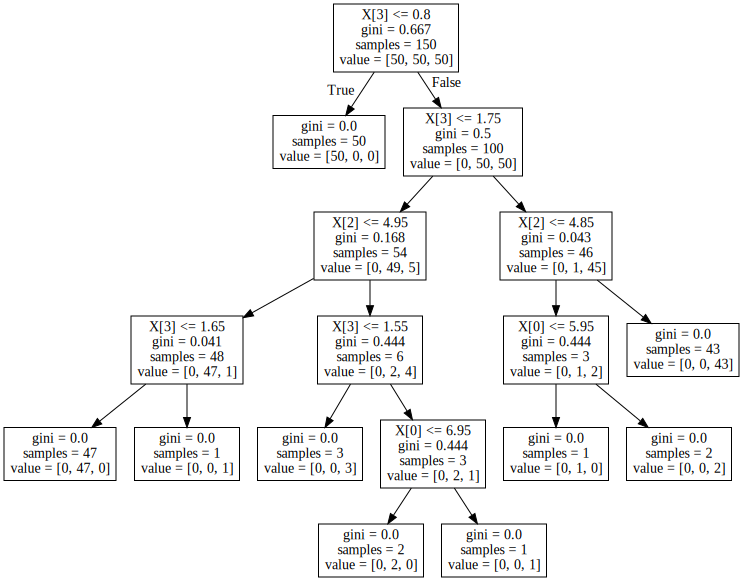

In [22]:
import numpy as np
from sklearn.tree import export_graphviz
import graphviz
import os
# https://graphviz.org/download/ --> goto install Graphviz for your Operating System(OS), 
# not only ' pip install graphviz ' graphviz for python package.
os.environ["PATH"] += os.pathsep + "D:/miniconda/Graphviz/bin/"

# the class for solution assignment 5.2
class LeastSqRTree:
  def __init__(self, train_X, y, epsilon):
    self.x = train_X  # 训练集特征值
    self.y = y  # 类别
    self.feature_count = train_X.shape[1]  # 特征总数
    self.epsilon = epsilon  # 损失阈值
    self.tree = None  # 回归树

  def _fit(self, x, y, feature_count, epsilon):
    # 选择最优切分点变量j与切分点s
    (j, s, minval, c1, c2) = self._divide(x, y, feature_count)
    # 初始化树
    tree = {"feature": j, "value": x[s, j], "left": None, "right": None}
    if minval < self.epsilon or len(y[np.where(x[:, j] <= x[s, j])]) <= 1:
      tree["left"] = c1
    else:
      tree["left"] = self._fit(x[np.where(x[:, j] <= x[s, j])], y[np.where(x[:, j] <= x[s, j])], self.feature_count, self.epsilon)
    if minval < self.epsilon or len(y[np.where(x[:, j] > s)]) <= 1:
      tree["right"] = c2
    else:
      tree["right"] = self._fit(x[np.where(x[:, j] > x[s, j])], y[np.where(x[:, j] > x[s, j])], self.feature_count, self.epsilon)
    return tree

  def fit(self):
    self.tree = self._fit(self.x, self.y, self.feature_count, self.epsilon)

  @staticmethod
  def _divide(x, y, feature_count):
    # 初始化损失误差
    cost = np.zeros((feature_count, len(x)))
    # 公式5.21
    for i in range(feature_count):
      for k in range(len(x)):
        # k行i列的特征值
        value = x[k, i]
        y1 = y[np.where(x[:, i] <= value)]
        c1 = np.mean(y1)
        y2 = y[np.where(x[:, i] > value)]
        c2 = np.mean(y2)
        y1[:] = y1[:] - c1
        y2[:] = y2[:] - c2
        cost[i, k] = np.sum(y1 * y1) + np.sum(y2 * y2)
    # 选取最优损失误差点
    cost_index = np.where(cost == np.min(cost))
    # 选取第几个特征值
    j = cost_index[0][0]
    # 选取特征值的切分点
    s = cost_index[1][0]
    # 求两个区域的均值c1,c2
    c1 = np.mean(y[np.where(x[:, j] <= x[s, j])])
    c2 = np.mean(y[np.where(x[:, j] > x[s, j])])
    return j, s, cost[cost_index], c1, c2

# ----------------------------------------------
# TEST
train_X = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]).T
y = np.array([4.50, 4.75, 4.91, 5.34, 5.80, 7.05, 7.90, 8.23, 8.70, 9.00])

model_tree = LeastSqRTree(train_X, y, .2)
model_tree.fit()
# the Visualization of Decision Trss. 
tree_pic = export_graphviz(clf, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph